## Loosely based on Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)

In [75]:
import keras, os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dropout, Embedding, Flatten, Dense, SimpleRNN, LSTM, GRU, Bidirectional
from keras.models import Sequential
from keras import layers
%matplotlib inline

model_dir = 'models'

In [44]:
def summarize_history(history):
    acc = history.history['acc']
    loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    fig, ax = plt.subplots()
    ax.plot(epochs, acc, 'bo-', label='Train acc')
    ax.plot(epochs, loss, 'b--', label='Train loss')
    ax.plot(epochs, val_acc, 'ro-', label='Val acc')
    ax.plot(epochs, val_loss, 'r--', label='Val loss')
    ax.set(ylim=[0, None],
           xlabel='Epoch')
    ax.legend()
    print('Best validation accuracy: {} after epoch {}'.format(np.max(val_acc), np.argmax(val_acc) + 1))

In [3]:
data_folder = 'aclImdb'
train_dir = os.path.join(data_folder, 'train')

labels = []
texts = []

def parse_txt_file(fname):
    with open(fname, 'r') as f:
        return f.read()

def parse_folder(folder):
    texts = []
    for fname in os.listdir(folder):
        if fname.endswith('.txt'):
            texts.append(parse_txt_file(os.path.join(folder, fname)))
    return texts

def parse_data(directory): 
    neg_texts = parse_folder(os.path.join(directory, 'neg'))
    pos_texts = parse_folder(os.path.join(directory, 'pos'))
    labels = [0] * len(neg_texts)
    labels.extend([1] * len(pos_texts))
    return neg_texts + pos_texts, labels

texts, labels = parse_data(train_dir)

In [4]:
texts_train, texts_val, y_train, y_val = train_test_split(texts, labels, test_size=0.20, shuffle=True, random_state=42)

In [86]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 500
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(texts_train)
x_train = pad_sequences(tokenizer.texts_to_sequences(texts_train), maxlen=maxlen)
x_val = pad_sequences(tokenizer.texts_to_sequences(texts_val), maxlen=maxlen)

In [6]:
word_index = tokenizer.word_index
print('Found {} unique word tokens'.format(len(word_index)))

Found 80080 unique word tokens


### Model with word embedding and a small DNN classifier

In [7]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save(os.path.join(model_dir, 'imdb-embedding.h5'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 222us/step - loss: 0.4364 - acc: 0.7870 - val_loss: 0.3466 - val_acc: 0.8436
Epoch 2/10
20000/20000 [==============================] - 4s 210us/step - loss: 0.1423 - acc: 0.9491 - val_loss: 0.4629 - val_acc: 0.8166
Epoch 3/10
20000/20000 [==============================] - 4s 213us/step - loss: 0.0172 - acc: 0.9950 - val_loss: 0.6800 - val_acc: 0.8124
Epoch 4/10
20000/20000 [==============================] - 4s 205us/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.9403 - val_acc: 0.8092
Epoch 5/10
20000/20000 [==============================] - 4s 204us/step - loss: 2.5251e-05 - acc: 1.0000 - val_loss: 1.1062 - val_acc: 0.8144
Epoch 6/10
20000/20000 [==============================] - 4s 209us/step - loss: 2.2474e-07 - acc: 1.0000 - val_loss: 1.2118 - val_acc: 0.8120
Epoch 7/10
20000/20000 [==============================] - 4s 206us/step - loss: 1.1143e-07 - acc: 1.0000 - val_loss

Best validation accuracy: 0.8374 after epoch 2


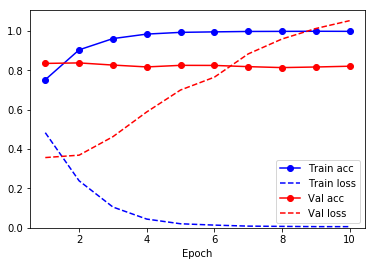

In [46]:
summarize_history(history)

Try Dropout to combat overfitting:

In [38]:
import keras.backend as K
from keras.layers import Lambda
model = Sequential()
model.add(Dropout(rate=0.20, seed=42, input_shape=(maxlen,)))
def cast_to_int(x):
    return K.cast(x, dtype='int32')
model.add(Lambda(cast_to_int))

np.max(x_train - model.predict(x_train))

0

In [39]:
def cast_to_int(x):
    return K.cast(x, dtype='int32')

model = Sequential()
# model.add(Dropout(rate=0.20, seed=42, input_shape=(maxlen,)))
# model.add(Lambda(cast_to_int))
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Dropout(rate=0.20, noise_shape=(None, maxlen, 1), seed=42))
model.add(Flatten())
model.add(Dropout(rate=0.20, seed=42))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
dropout_34 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 10000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save(os.path.join(model_dir, 'imdb-embedding-dropout.h5'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s 299us/step - loss: 0.4830 - acc: 0.7520 - val_loss: 0.3567 - val_acc: 0.8348
Epoch 2/10
20000/20000 [==============================] - 5s 253us/step - loss: 0.2387 - acc: 0.9037 - val_loss: 0.3688 - val_acc: 0.8374
Epoch 3/10
20000/20000 [==============================] - 5s 252us/step - loss: 0.1054 - acc: 0.9609 - val_loss: 0.4627 - val_acc: 0.8264
Epoch 4/10
20000/20000 [==============================] - 5s 255us/step - loss: 0.0443 - acc: 0.9837 - val_loss: 0.5884 - val_acc: 0.8170
Epoch 5/10
20000/20000 [==============================] - 5s 273us/step - loss: 0.0204 - acc: 0.9925 - val_loss: 0.6998 - val_acc: 0.8250
Epoch 6/10
20000/20000 [==============================] - 6s 279us/step - loss: 0.0137 - acc: 0.9950 - val_loss: 0.7649 - val_acc: 0.8246
Epoch 7/10
20000/20000 [==============================] - 5s 264us/step - loss: 0.0085 - acc: 0.9971 - val_loss: 0.8830 - v

Best validation accuracy: 0.8374 after epoch 2


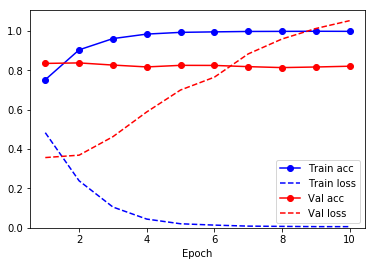

In [45]:
summarize_history(history)

### Simple RNN

In [52]:
embedding_dim = 32
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(SimpleRNN(32, dropout=0.10, recurrent_dropout=0.10))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save(os.path.join(model_dir, 'imdb-embedding-rnn.h5'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 17s 830us/step - loss: 0.7061 - acc: 0.5209 - val_loss: 0.6845 - val_acc: 0.5362
Epoch 2/10
20000/20000 [==============================] - 16s 799us/step - loss: 0.6794 - acc: 0.5575 - val_loss: 0.6632 - val_acc: 0.5884
Epoch 3/10
20000/20000 [==============================] - 16s 794us/step - loss: 0.6444 - acc: 0.6115 - val_loss: 0.6367 - val_acc: 0.6034
Epoch 4/10
20000/20000 [==============================] - 16s 802us/step - loss: 0.5873 - acc: 0.6853 - val_loss: 0.5589 - val_acc: 0.7114
Epoch 5/10
20000/20000 [==============================] - 16s 780us/step - loss: 0.5251 - acc: 0.7421 - val_loss: 0.5338 - val_acc: 0.7374
Epoch 6/10
20000/20000 [==============================] - 17s 827us/step - loss: 0.4852 - acc: 0.7741 - val_loss: 0.5051 - val_acc: 0.7606
Epoch 7/10
20000/20000 [==============================] - 16s 776us/step - loss: 0.4600 - acc: 0.7939 - val_loss: 0.4

Best validation accuracy: 0.7702 after epoch 9


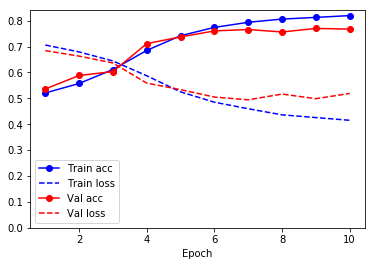

In [55]:
summarize_history(history)

### Try the more powerful LSTM

In [60]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32, dropout=0.10, recurrent_dropout=0.10))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
model.save(os.path.join(model_dir, 'imdb-embedding-lstm.h5'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 18s 920us/step - loss: 0.5290 - acc: 0.7512 - val_loss: 0.3669 - val_acc: 0.8402
Epoch 2/10
20000/20000 [==============================] - 16s 799us/step - loss: 0.3498 - acc: 0.8602 - val_loss: 0.3513 - val_acc: 0.8498
Epoch 3/10
20000/20000 [==============================] - 16s 802us/step - loss: 0.2924 - acc: 0.8854 - val_loss: 0.3381 - val_acc: 0.8566
Epoch 4/10
20000/20000 [==============================] - 17s 848us/step - loss: 0.2596 - acc: 0.9012 - val_loss: 0.3509 - val_acc: 0.8550
Epoch 5/10
20000/20000 [==============================] - 17s 848us/step - loss: 0.2354 - acc: 0.9092 - val_loss: 0.5336 - val_acc: 0.8040
Epoch 6/10
20000/20000 [==============================] - 16s 814us/step - loss: 0.2147 - acc: 0.9186 - val_loss: 0.3653 - val_acc: 0.8492
Epoch 7/10
20000/20000 [==============================] - 16s 806us/step - loss: 0.1990 - acc: 0.9265 - val_loss: 0.4

Best validation accuracy: 0.8566 after epoch 3


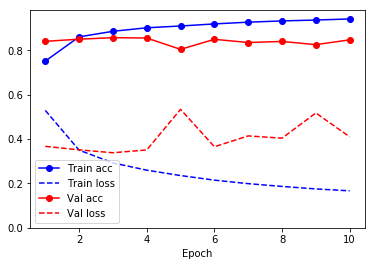

In [62]:
summarize_history(history)

### GRU layer

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(GRU(32, dropout=0.10, recurrent_dropout=0.10))
model.add(Dense(1, activation='sigmoid'))

model.summary()

In [65]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
model.save(os.path.join(model_dir, 'imdb-embedding-gru.h5'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 14s 716us/step - loss: 0.3902 - acc: 0.8333 - val_loss: 0.4230 - val_acc: 0.8086
Epoch 2/10
20000/20000 [==============================] - 13s 657us/step - loss: 0.3288 - acc: 0.8669 - val_loss: 0.3780 - val_acc: 0.8296
Epoch 3/10
20000/20000 [==============================] - 13s 658us/step - loss: 0.2928 - acc: 0.8840 - val_loss: 0.4213 - val_acc: 0.8096
Epoch 4/10
20000/20000 [==============================] - 13s 645us/step - loss: 0.2727 - acc: 0.8925 - val_loss: 0.3767 - val_acc: 0.8348
Epoch 5/10
20000/20000 [==============================] - 12s 603us/step - loss: 0.2507 - acc: 0.9043 - val_loss: 0.4279 - val_acc: 0.8228
Epoch 6/10
20000/20000 [==============================] - 12s 605us/step - loss: 0.2318 - acc: 0.9111 - val_loss: 0.4343 - val_acc: 0.8200
Epoch 7/10
20000/20000 [==============================] - 12s 602us/step - loss: 0.2180 - acc: 0.9191 - val_loss: 0.3

Best validation accuracy: 0.8484 after epoch 7


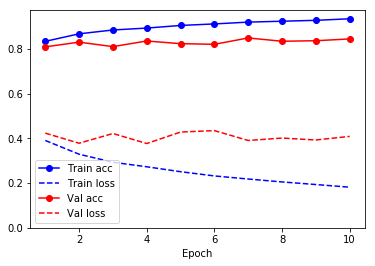

In [67]:
summarize_history(history)

## Bidirectional LSTM

In [68]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(32, dropout=0.10, recurrent_dropout=0.10)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
model.save(os.path.join(model_dir, 'imdb-embedding-bidir-lstm.h5'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.5337 - acc: 0.7340 - val_loss: 0.3966 - val_acc: 0.8294
Epoch 2/10
20000/20000 [==============================] - 19s 940us/step - loss: 0.3454 - acc: 0.8569 - val_loss: 0.3551 - val_acc: 0.8420
Epoch 3/10
20000/20000 [==============================] - 19s 954us/step - loss: 0.2793 - acc: 0.8935 - val_loss: 0.3665 - val_acc: 0.8394
Epoch 4/10
20000/20000 [==============================] - 19s 953us/step - loss: 0.2410 - acc: 0.9103 - val_loss: 0.3553 - val_acc: 0.8582
Epoch 5/10
20000/20000 [==============================] - 19s 959us/step - loss: 0.2180 - acc: 0.9198 - val_loss: 0.4177 - val_acc: 0.8568
Epoch 6/10
20000/20000 [==============================] - 19s 967us/step - loss: 0.1970 - acc: 0.9290 - val_loss: 0.3452 - val_acc: 0.8502
Epoch 7/10
20000/20000 [==============================] - 19s 970us/step - loss: 0.1857 - acc: 0.9331 - val_loss: 0.394

Best validation accuracy: 0.8582 after epoch 4


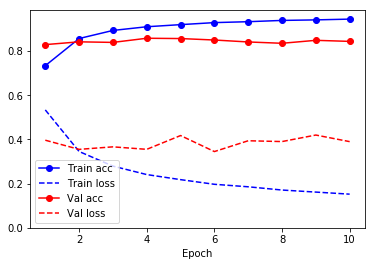

In [70]:
summarize_history(history)

## Stacking RNN layers

In [72]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(GRU(32,
              dropout=0.10, 
              recurrent_dropout=0.10,
              return_sequences=True))
model.add(GRU(64,
              dropout=0.10, 
              recurrent_dropout=0.10))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
gru_3 (GRU)                  (None, 100, 32)           6240      
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 344,929
Trainable params: 344,929
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
model.save(os.path.join(model_dir, 'imdb-embedding-gru-gru.h5'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.5256 - acc: 0.7344 - val_loss: 0.4825 - val_acc: 0.7572
Epoch 2/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.3551 - acc: 0.8509 - val_loss: 0.3979 - val_acc: 0.8196
Epoch 3/10
20000/20000 [==============================] - 24s 1ms/step - loss: 0.2940 - acc: 0.8813 - val_loss: 0.3481 - val_acc: 0.8538
Epoch 4/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.2625 - acc: 0.8996 - val_loss: 0.3690 - val_acc: 0.8406
Epoch 5/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.2362 - acc: 0.9121 - val_loss: 0.3906 - val_acc: 0.8368
Epoch 6/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.2179 - acc: 0.9198 - val_loss: 0.4010 - val_acc: 0.8378
Epoch 7/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.2020 - acc: 0.9254 - val_loss: 0.3862 - val_acc:

Best validation accuracy: 0.8538 after epoch 3


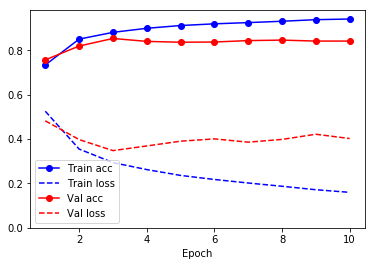

In [79]:
summarize_history(history)

## 1D convolutional network

In [80]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(64, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 94, 32)            7200      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 18, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 12, 64)            14400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 341,665
Trainable params: 341,665
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
model.save(os.path.join(model_dir, 'imdb-embedding-conv-1d.h5'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 199us/step - loss: 0.5544 - acc: 0.6966 - val_loss: 0.4081 - val_acc: 0.8100
Epoch 2/10
20000/20000 [==============================] - 2s 118us/step - loss: 0.3356 - acc: 0.8556 - val_loss: 0.3998 - val_acc: 0.8208
Epoch 3/10
20000/20000 [==============================] - 2s 121us/step - loss: 0.2727 - acc: 0.8885 - val_loss: 0.4267 - val_acc: 0.8186
Epoch 4/10
20000/20000 [==============================] - 2s 122us/step - loss: 0.2302 - acc: 0.9082 - val_loss: 0.4160 - val_acc: 0.8252
Epoch 5/10
20000/20000 [==============================] - 2s 122us/step - loss: 0.1940 - acc: 0.9263 - val_loss: 0.4349 - val_acc: 0.8242
Epoch 6/10
20000/20000 [==============================] - 2s 120us/step - loss: 0.1591 - acc: 0.9423 - val_loss: 0.4802 - val_acc: 0.8172
Epoch 7/10
20000/20000 [==============================] - 2s 121us/step - loss: 0.1226 - acc: 0.9568 - val_loss: 0.5045 - v

Best validation accuracy: 0.8252 after epoch 4


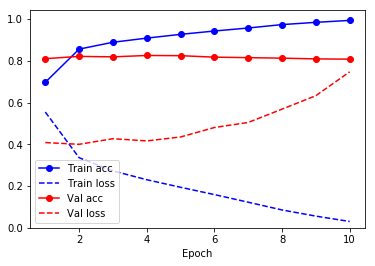

In [82]:
summarize_history(history)

## Combining 1D convolutional network with RNNs

In [88]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 500, 32)           320000    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 494, 32)           7200      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 164, 32)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 158, 32)           7200      
_________________________________________________________________
gru_6 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 33        
Total params: 340,673
Trainable params: 340,673
Non-trainable params: 0
_________________________________________________________________


In [89]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
model.save(os.path.join(model_dir, 'imdb-embedding-conv-1d-gru.h5'))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.5494 - acc: 0.7079 - val_loss: 0.4497 - val_acc: 0.7884
Epoch 2/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.3631 - acc: 0.8454 - val_loss: 0.4155 - val_acc: 0.8128
Epoch 3/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.2984 - acc: 0.8781 - val_loss: 0.3838 - val_acc: 0.8272
Epoch 4/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.2572 - acc: 0.8969 - val_loss: 0.4293 - val_acc: 0.8292
Epoch 5/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.2188 - acc: 0.9123 - val_loss: 0.3635 - val_acc: 0.8456
Epoch 6/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.1944 - acc: 0.9268 - val_loss: 0.4360 - val_acc: 0.8268
Epoch 7/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.1644 - acc: 0.9379 - val_loss: 0.4250 - val_acc:

Best validation accuracy: 0.8488 after epoch 10


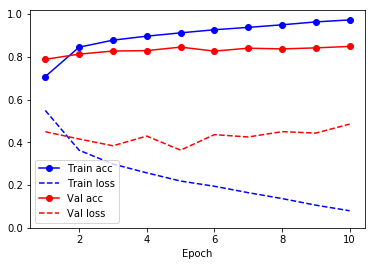

In [90]:
summarize_history(history)